In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np

!pip install gym[classic_control]
!pip install gym[box2d] #for lunarlander
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper
import gnwrapper
!nvidia-smi
print(torch.cuda.is_available())

In [22]:
##########################
##Representation Network
##input : raw input
##output : hs(hidden state) 
class Representation(nn.Module): 
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.layer3 = torch.nn.Linear(width, output_dim)     
        
    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)        
        return x

#######################
##Dynamics Network        
##input : hs, action
##output : next_hs, reward 
class Dynamics(nn.Module): 
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim + 1, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.hs_head = torch.nn.Linear(width, output_dim)
        self.reward_head = torch.nn.Linear(width, 1)
       
    def forward(self, x, action):
        action = torch.tensor([action])
        x = torch.cat((x,action), dim=0)
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        hs = self.hs_head(x)
        reward = self.reward_head(x)     
        return hs, reward

######################
##Prediction Network
##input : hs
##output : P, V 
class Prediction(nn.Module): 
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.policy_head = torch.nn.Linear(width, output_dim)
        self.value_head = torch.nn.Linear(width, 1) 
   
    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        P = self.policy_head(x)
        P = torch.nn.functional.softmax(P, dim=0) 
        V = self.value_head(x)      
        return P, V

#####################
##Target network
class Target(nn.Module):
    def __init__(self, state_dim, action_dim, width, target=0):
        super().__init__()
        self.representation_network = Representation(state_dim, state_dim//2, width) 
        self.dynamics_network = Dynamics(state_dim//2, state_dim//2, width)
        self.prediction_network = Prediction(state_dim//2, action_dim, width) 

########################
##Muesli agent
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, width, target=0):
        super().__init__()
        self.representation_network = Representation(state_dim, state_dim//2, width) 
        self.dynamics_network = Dynamics(state_dim//2, state_dim//2, width)
        self.prediction_network = Prediction(state_dim//2, action_dim, width) 
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.0003, weight_decay=0)
        #self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.999)     
        self.to(device)
        self.train()

        self.state_traj = []
        self.action_traj = []
        self.P_traj = []
        self.r_traj = []      

        self.state_replay = []
        self.action_replay = []
        self.P_replay = []
        self.r_replay = []   

        self.action_space = action_dim
        self.env = gym.make(game_name)     

    def self_play_mu(self, max_timestep=10000):        
        #self play with 1st inferenced policy    
        game_score = 0
        state = self.env.reset()
        for i in range(max_timestep):   
            start_state = state
            with torch.no_grad():
                hs = self.representation_network(torch.from_numpy(state).float().to(device))
                P, v = self.prediction_network(hs)    
            action = np.random.choice(np.arange(self.action_space), p=P.detach().numpy())   
            state, r, done, _ = self.env.step(action)                    
            self.state_traj.append(start_state)
            self.action_traj.append(action)
            self.P_traj.append(P)
            self.r_traj.append(r)
            game_score += r
            if done:
                break

        # for update inference over trajectory length
        self.state_traj.append(np.zeros_like(state))
        self.state_traj.append(np.zeros_like(state))
        self.r_traj.append(torch.tensor(0))
        self.action_traj.append(np.random.randint(self.action_space))       

        # traj append to replay
        self.state_replay.append(self.state_traj)
        self.action_replay.append(self.action_traj)
        self.P_replay.append(self.P_traj)
        self.r_replay.append(self.r_traj)  

        return game_score 

    def target_performence_test(self, target, max_timestep=10000):        
        ## self play with 1st inferenced policy    
        game_score = 0
        state = self.env.reset()
        for i in range(max_timestep):   
            start_state = state
            with torch.no_grad():
                hs = target.representation_network(torch.from_numpy(state).float().to(device))
                P, v = target.prediction_network(hs)    
            action = np.random.choice(np.arange(self.action_space), p=P.detach().numpy())   
            state, r, done, _ = self.env.step(action)                 
            game_score += r
            if done:
                break

        return game_score 

    def update_weights_mu(self, target):
        for _ in range(20): ## number of minibatch
            Cumul_L_total = 0
            for epi_sel in range(6): ## number of selected episode in a batch
                if(epi_sel>0):## replay proportion
                    sel = np.random.randint(0,len(self.state_replay))    
                    self.state_traj = self.state_replay[sel]
                    self.action_traj = self.action_replay[sel]
                    self.P_traj = self.P_replay[sel]
                    self.r_traj = self.r_replay[sel]

                ## multi step return G (orignally retrace used)
                G = 0
                G_arr = []
                for r in self.r_traj[::-1]:
                    G = 0.99 * G + r
                    G_arr.append(G)
                G_arr.reverse()
                G_arr.append(torch.tensor(0))
                G_arr.append(torch.tensor(0))

                for i in np.random.randint(len(self.state_traj)-2,size=5): ## number of selected transition in a replay

                    ## update inference (2 step unroll. originally 5 step unroll recommended)                
                    first_hs = self.representation_network(torch.from_numpy(self.state_traj[i]).float().to(device))## do not have to stack more than 1 frame
                    first_P, first_v = self.prediction_network(first_hs)      
                    
                    second_hs, r = self.dynamics_network(first_hs, self.action_traj[i])    
                    second_P, second_v = self.prediction_network(second_hs)

                    third_hs, r2 = self.dynamics_network(second_hs, self.action_traj[i+1])    
                    third_P, third_v = self.prediction_network(third_hs)
                    
                    ## target network inference
                    with torch.no_grad():
                        t_first_hs = target.representation_network(torch.from_numpy(self.state_traj[i]).float().to(device))
                        t_first_P, t_first_v = target.prediction_network(t_first_hs)                 

                    ## L_pg_cmpo first term (eq.10)      
                    importance_weight = torch.clip(first_P.gather(0,torch.tensor(self.action_traj[i]))
                                                /(self.P_traj[i].gather(0,torch.tensor(self.action_traj[i])).item()),
                                                0, 1
                    )
                    first_term = -1 * importance_weight * (G_arr[i].item() - t_first_v.item())  
                    
                    ##lookahead inferences (one step look-ahead to some actions to estimate q_prior, from target network)
                    with torch.no_grad():                                
                        r1_arr = []
                        v1_arr = []
                        a1_arr = []
                        for _ in range(self.action_space): #sample <= N(action space), now N                 
                            action1 = np.random.choice(np.arange(self.action_space), p=t_first_P.detach().numpy())#prior pi                                             
                            hs, r1 = target.dynamics_network(t_first_hs, action1)
                            _, v1 = target.prediction_network(hs)
                            r1_arr.append(r1)
                            v1_arr.append(v1) 
                            a1_arr.append(action1)
                    
                    ## z_cmpo_arr (eq.12)
                    with torch.no_grad():
                        adv_arr = []
                        for r1, v1 in zip(r1_arr, v1_arr):
                            adv =  r1 + 0.99 * v1 - t_first_v # adv = q_prior - v_prior. q_prior = r1 + gamma* v1
                            adv_arr.append(adv)
                        
                        exp_clip_adv_arr = [torch.exp(torch.clip(adv_arr[k], -1, 1)) for k in range(self.action_space)]

                        z_cmpo_arr = []
                        for k in range(self.action_space):
                            z_cmpo = (1 + torch.sum(torch.tensor(exp_clip_adv_arr)) - exp_clip_adv_arr[k]) / self.action_space 
                            z_cmpo_arr.append(z_cmpo)

                    ## L_pg_cmpo second term (eq.11)
                    second_term = 0
                    for k in range(self.action_space):
                        second_term += exp_clip_adv_arr[k]/z_cmpo_arr[k] * torch.log(first_P.gather(0, torch.tensor(a1_arr[k])))
                    regularizer_multiplier = 5 
                    second_term *= -1 * regularizer_multiplier / self.action_space

                    ## L_pg_cmpo               
                    L_pg_cmpo = first_term + second_term

                    ## L_v               
                    L_v = (
                        ((first_v - G_arr[i].item())**2)/2 
                        + ((second_v - G_arr[i+1].item())**2)/2 
                        + ((third_v - G_arr[i+2].item())**2)/2
                    )

                    ## L_r
                    L_r = ((r - self.r_traj[i])**2)/2 + ((r2-self.r_traj[i+1])**2)/2                
                    
                    ## L_m (eq 7, eq 13)
                    L_m = 0
                    m_adv_arr = [] 
                    with torch.no_grad(): 
                        m_hs = target.representation_network(torch.from_numpy(self.state_traj[i+1]).float().to(device))
                        m_P, m_v = target.prediction_network(m_hs)
                        for j in range(self.action_space):                         
                            hs, r = target.dynamics_network(m_hs, j)    
                            _, v = target.prediction_network(hs)
                            m_adv = r + 0.99 * v - m_v                        
                            m_adv_arr.append(torch.exp(torch.clip(m_adv,-1,1)))                    
                        pi_cmpo_all = [m_P[j]*m_adv_arr[j]/(1+sum(m_adv_arr)-m_adv_arr[j])*self.action_space for j in range(self.action_space)]
                        pi_cmpo_all=torch.tensor(pi_cmpo_all)   
                    kl_loss = torch.nn.KLDivLoss()
                    L_m += kl_loss(F.log_softmax(second_P, dim=0), F.softmax(pi_cmpo_all,dim=0))#input, target      

                    m_adv_arr = []               
                    with torch.no_grad(): 
                        m_hs = target.representation_network(torch.from_numpy(self.state_traj[i+2]).float().to(device))
                        m_P, m_v = target.prediction_network(m_hs)
                        for j in range(self.action_space):                         
                            hs, r = target.dynamics_network(m_hs, j)    
                            _, v = target.prediction_network(hs)
                            m_adv = r + 0.99 * v - m_v
                            m_adv_arr.append(torch.exp(torch.clip(m_adv,-1,1)))             
                        pi_cmpo_all = [m_P[j]*m_adv_arr[j]/(1+sum(m_adv_arr)-m_adv_arr[j])*self.action_space for j in range(self.action_space)]
                        pi_cmpo_all=torch.tensor(pi_cmpo_all)    
                    kl_loss = torch.nn.KLDivLoss()
                    L_m += kl_loss(F.log_softmax(third_P, dim=0) , F.softmax(pi_cmpo_all,dim=0)) 
                    L_m /= 2  
                    
                    L_total = L_pg_cmpo + L_v/3/4 + L_r/2 + L_m/4                 

                    Cumul_L_total += L_total

            Cumul_L_total /= 30
            self.optimizer.zero_grad()
            Cumul_L_total.backward()

            nn.utils.clip_grad_value_(self.parameters(), clip_value=1.0)

            ## dynamics network gradient scale 1/2   
            for d in self.dynamics_network.parameters():
                d.grad *= 0.5

            self.optimizer.step()

            ## target network(prior parameters) moving average update
            alpha_target = 0.01 
            params1 = self.named_parameters()
            params2 = target.named_parameters()
            dict_params2 = dict(params2)
            for name1, param1 in params1:
                if name1 in dict_params2:
                    dict_params2[name1].data.copy_(alpha_target*param1.data + (1-alpha_target)*dict_params2[name1].data)
            target.load_state_dict(dict_params2)

        #self.scheduler.step()

        ##trajectory clear
        self.state_traj.clear()
        self.action_traj.clear()
        self.P_traj.clear()
        self.r_traj.clear()
        return
        
device = torch.device('cpu')
score_arr = []
game_name = 'CartPole-v1'  
env = gym.make(game_name) 
target = Target(env.observation_space.shape[0], env.action_space.n, 128)
agent = Agent(env.observation_space.shape[0], env.action_space.n, 128)  
print(agent)
env.close()

target.load_state_dict(agent.state_dict())

#Self play, weight update
episode_nums = 1000 
for i in range(episode_nums):    
    if i%30==0:             
        params1 = agent.named_parameters()
        params2 = target.named_parameters()
        dict_params2 = dict(params2)
        for name1, param1 in params1:
            if name1 in dict_params2:
                dict_params2[name1].data.copy_(0.5*param1.data + 0.5*dict_params2[name1].data)
        target.load_state_dict(dict_params2)

    game_score = agent.self_play_mu()       
    score_arr.append(game_score)  

    if i%10==0:
        print('episode', i)    
        print('score', game_score)
        t_game_score = agent.target_performence_test(target)
        print('t_score', t_game_score)

    if np.mean(np.array(score_arr[i-5:i])) > 400:
        torch.save(agent.state_dict(), 'weights.pt')
        break

    agent.update_weights_mu(target) 

torch.save(agent.state_dict(), 'weights.pt') 
agent.env.close()



/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/num

Agent(
  (representation_network): Representation(
    (layer1): Linear(in_features=4, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=128, bias=True)
    (layer3): Linear(in_features=128, out_features=2, bias=True)
  )
  (dynamics_network): Dynamics(
    (layer1): Linear(in_features=3, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=128, bias=True)
    (hs_head): Linear(in_features=128, out_features=2, bias=True)
    (reward_head): Linear(in_features=128, out_features=1, bias=True)
  )
  (prediction_network): Prediction(
    (layer1): Linear(in_features=2, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=128, bias=True)
    (policy_head): Linear(in_features=128, out_features=2, bias=True)
    (value_head): Linear(in_features=128, out_features=1, bias=True)
  )
)
episode 0
score 26.0
t_score 38.0
episode 10
score 23.0
t_score 18.0
episode 20
score 12.0
t_score 11.0
episode 30
score 12.0
t_sco

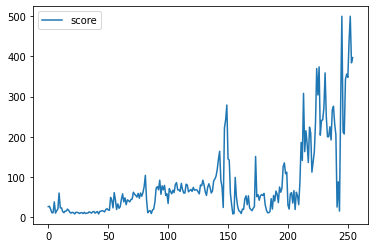

In [23]:
## Earned score per episode
plt.plot(score_arr, label ='score')
plt.legend(loc='upper left')

/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


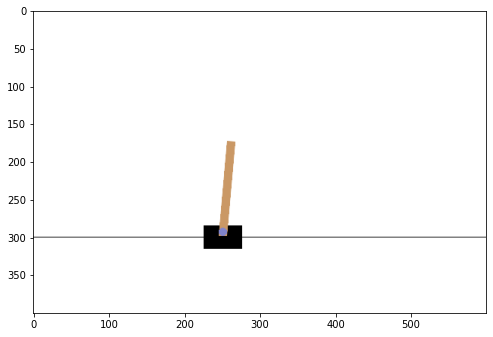

In [21]:
## game play video
agent.load_state_dict(torch.load("weights.pt"))
env = gnwrapper.LoopAnimation(gym.make(game_name)) 
state = env.reset()
for _ in range(100):
    with torch.no_grad():
        hs = agent.representation_network(torch.from_numpy(state).float().to(device))
        P, v = agent.prediction_network(hs)
        action = np.random.choice(np.arange(agent.action_space), p=P.detach().numpy())   
    env.render()
    state, rew, done, _ = env.step(action.item())
    if done:
        state = env.reset()
env.display()